In [1]:
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import pickle
from tqdm import tqdm_notebook
from multiprocessing import Pool

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
def evaluate(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return prec, recall, f1

## Data Preparation

In [3]:
training_date  = [(2018, 7), (2018, 8),(2018, 9),(2018, 10),(2018, 11), (2018, 12)]

testing_date   = [(2019, 1),(2019, 2),(2019, 3),(2019, 4),(2019, 5),(2019, 6)]

train_data= [np.load('../../user_data/CloudMile/data/data_{}_{}.npz'.format(year, month), 
                     allow_pickle=True) 
             for year, month in training_date]

test_data= [np.load('../../user_data/CloudMile/data/data_{}_{}.npz'.format(year,  month), 
                    allow_pickle=True) 
            for year, month in testing_date]

X_train = np.concatenate([data['arr_0'] for data in train_data])
y_train = np.concatenate([data['arr_1'] for data in train_data])
training_announce = np.concatenate([data['arr_2'] for data in train_data])
training_FILTER = np.concatenate([data['arr_3'] for data in train_data])

X_test = np.concatenate([data['arr_0'] for data in test_data])
y_test = np.concatenate([data['arr_1'] for data in test_data])
testing_announce = np.concatenate([data['arr_2'] for data in test_data])
testing_FILTER = np.concatenate([data['arr_3'] for data in test_data])

In [4]:
X_train = X_train[:,0,:]
X_test = X_test[:,0,:]

# X_train = np.hstack([X_train[:,:314], X_train[:,-14:]])
# X_test = np.hstack([X_test[:,:314], X_test[:,-14:]])

In [5]:
### Announce Extract
X_train = X_train[training_announce == 1]
y_train = y_train[training_announce == 1]

X_test = X_test[testing_announce == 1]
y_test = y_test[testing_announce == 1]

In [6]:
clf = XGBClassifier(n_estimators=100,
                    learning_rate= 0.1,     
                    max_depth=5, 
                    subsample=1,
                    gamma=0, 
                    reg_lambda=1, 
                    max_delta_step=0,
                    colsample_bytree=1, 
                    min_child_weight=1, 
                    seed=1000)

In [7]:
%%time
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)] , eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.968775
[1]	validation_0-auc:0.965589
[2]	validation_0-auc:0.967518
[3]	validation_0-auc:0.972932
[4]	validation_0-auc:0.97445
[5]	validation_0-auc:0.97506
[6]	validation_0-auc:0.975184
[7]	validation_0-auc:0.974985
[8]	validation_0-auc:0.974562
[9]	validation_0-auc:0.974139
[10]	validation_0-auc:0.974823
[11]	validation_0-auc:0.974848
[12]	validation_0-auc:0.974761
[13]	validation_0-auc:0.974774
[14]	validation_0-auc:0.973031
[15]	validation_0-auc:0.972832
[16]	validation_0-auc:0.971351
[17]	validation_0-auc:0.972844
[18]	validation_0-auc:0.974014
[19]	validation_0-auc:0.974238
[20]	validation_0-auc:0.973392
[21]	validation_0-auc:0.973193
[22]	validation_0-auc:0.972571
[23]	validation_0-auc:0.972372
[24]	validation_0-auc:0.973093
[25]	validation_0-auc:0.972919
[26]	validation_0-auc:0.973467
[27]	validation_0-auc:0.973118
[28]	validation_0-auc:0.973691
[29]	validation_0-auc:0.974761
[30]	validation_0-auc:0.975085
[31]	validation_0-auc:0.975632
[32]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1000, silent=None,
       subsample=1, verbosity=1)

In [8]:
pred_y_train = clf.predict_proba(X_train)[:,1]
pred_y_test  = clf.predict_proba(X_test)[:,1]

In [9]:
import matplotlib.pyplot as plt

In [16]:
def plotting(pred_y_list, label_list, save_path=False, stat='Train'):
    ###########################################################
    plt.ylabel('Log Count')
    plt.xlabel('Score')
    plt.yscale('log')
    
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    
    plt.grid(color = '#9999CC')
    plt.hist(pred_y_list[np.where(label_list == 0)], 
             bins=[n/200 for n in range(200)], 
             label='Negative',
             color='#598987')
    plt.hist(pred_y_list[np.where(label_list == 1)], 
             bins=[n/200 for n in range(200)], 
             label='Positive', 
             color='#FFD000')
    plt.legend(loc='upper right')
    if save_path:
        plt.savefig("result/{}_{}_1.jpg".format(save_path, stat), dpi=1000, quality=100)
    plt.show()
    ###########################################################
    plt.ylabel('Log Count')
    plt.xlabel('Score')
    plt.yscale('log')
    
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    
    plt.grid(color = '#9999CC')
    plt.hist(pred_y_list[np.where(label_list == 0)], 
             bins=[n/1000 for n in range(35)], 
             label='Negative', 
             color='#598987')
    plt.hist(pred_y_list[np.where(label_list == 1)], 
             bins=[n/1000 for n in range(35)], 
             label='Positive', 
             color='#FFD000')
    plt.legend(loc='upper right')
    if save_path:
        plt.savefig("result/{}_{}_2.jpg".format(save_path, stat), dpi=1000, quality=100)
    plt.show()

    
# y_train, pred_y_train
# y_test, pred_y_test  

# def func(label_list, pred_y_list, save_path=False):
def func(y_train, pred_y_train, y_test, pred_y_test, save_path=False):   
    auc_train = roc_auc_score(y_train, pred_y_train)
    auc_test  = roc_auc_score(y_test, pred_y_test)
    
    thres1 = np.min(pred_y_train[np.where(y_train == 1)])
    print('Training => auc: {:.6f}'.format(auc_train))
    print("Threshold is set to {}".format(thres1))
    
    y_predict_bin = np.array(pred_y_train >= thres1, dtype=int)
    prec_train, recall_train, f1_train = evaluate(y_train, y_predict_bin)
    print('prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}'.format(prec_train, recall_train, f1_train))
    
    print ("Total Positve: {}".format(len(np.where(y_train == 1)[0])))
    num_cand = np.sum(pred_y_train >= thres1)
    print ("Total Candidate: {}".format(num_cand))
#     print ("Negative Q95: {}".format(thres2))
    plotting(pred_y_train, y_train, save_path)
    
#     pd.DataFrame([pred_y_train, y_train, training_announce.tolist()], 
#                  index=['score', 'label', 'annouce']).T.to_csv('result/FeatEmbed_XGB_Training_res_Part2.csv', index=None)
    
    ##### Testing #####
    # thres2 = np.min(pred_y_test[np.where(y_test == 1)])
    ratio = 0.05
    thres2 = sorted(pred_y_test, reverse=True)[int(y_test.sum() + int(len(y_test)*ratio))]
    print("Recall of Testing = 1 : {}".format(thres2 > np.min(pred_y_test)))
    print('Testing => auc: {:.6f}'.format(auc_test))
    print("Threshold is set to {}".format(thres2))
    
    y_predict_bin = np.array(pred_y_test >= thres2, dtype=int)
    prec_test, recall_test, f1_test = evaluate(y_test, y_predict_bin)
    print('prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}'.format(prec_test, recall_test, f1_test))
    print("Total Positve: {}".format(np.sum(y_test)))
    print("Total Candidate: {}".format(np.sum(pred_y_test >= thres2)))
    print('----------------------------------------------')
    
    ## High Risk
    print("High Risk Positve: {}".format(np.sum(y_test[pred_y_test > thres1])))
    print("High Risk Candidate: {}".format(np.sum(pred_y_test > thres1)))
    print("High Risk Prec: {}".format(np.sum(y_test[np.where(pred_y_test > thres1)])/np.sum(pred_y_test > thres1)))
    print('----------------------------------------------')
    ## Medium Risk
    print("Medium Risk Positve: {}".format(np.sum(y_test[(pred_y_test <= thres1) & (pred_y_test > thres2)])))
    print("Medium Risk Candidate: {}".format(np.sum((pred_y_test <= thres1) & (pred_y_test > thres2))))
    print("Medium Risk Prec: {}".format(np.sum(y_test[np.where((pred_y_test <= thres1) & (pred_y_test > thres2))])/\
                                                             np.sum((pred_y_test <= thres1) & (pred_y_test > thres2))))
    plotting(pred_y_test, y_test, save_path, stat='Test')

#     pd.DataFrame([pred_y_test, y_test, testing_announce.tolist()], 
#                  index=['score', 'label', 'annouce']).T.to_csv('result/FeatEmbed_XGB_Testing_res_Part2.csv', index=None)

Training => auc: 1.000000
Threshold is set to 0.7225598692893982
prec: 1.0000, rec: 1.0000, F1score: 1.0000
Total Positve: 103
Total Candidate: 103


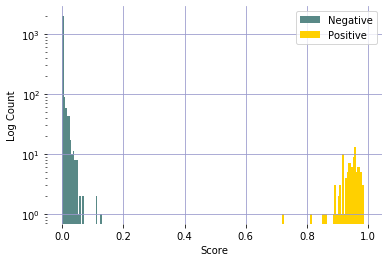

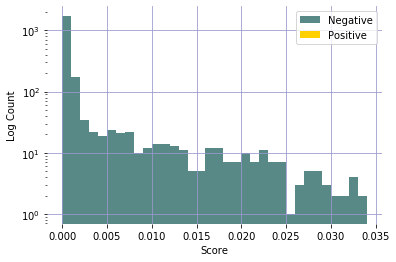

Recall of Testing = 1 : True
Testing => auc: 0.972745
Threshold is set to 0.020811058580875397
prec: 0.1145, rec: 0.8333, F1score: 0.2013
Total Positve: 18
Total Candidate: 131
----------------------------------------------
High Risk Positve: 1
High Risk Candidate: 1
High Risk Prec: 1.0
----------------------------------------------
Medium Risk Positve: 13
Medium Risk Candidate: 129
Medium Risk Prec: 0.10077519379844961


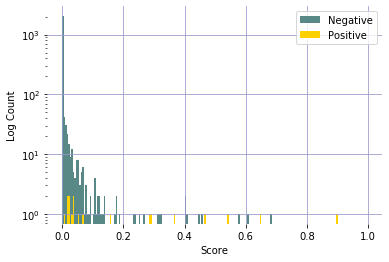

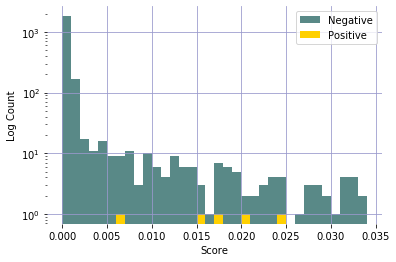

In [17]:
func(y_train, pred_y_train, y_test, pred_y_test, save_path='FeatEmbed_XGB_Part2')